In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

In [2]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
HLA_alleles = data_tools.load_HLA_data()

<AxesSubplot:xlabel='zygosity', ylabel='Count'>

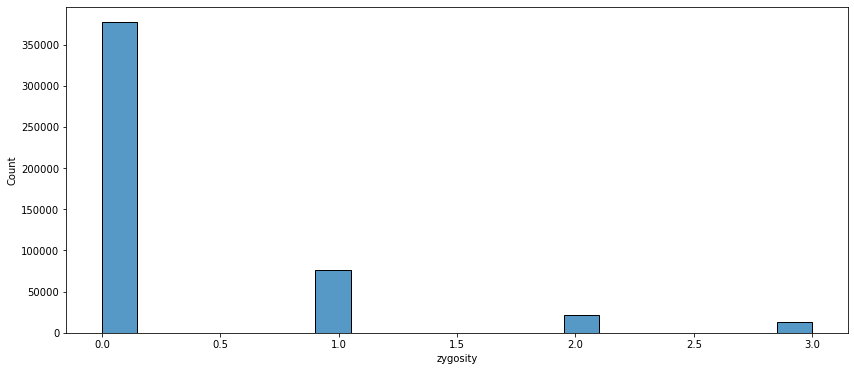

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.histplot(HLA_alleles["zygosity"], ax=ax)

# Add Grantham Distance

In [5]:
def calculate_effective_zygosity(HLA_alleles: pd.DataFrame, class_I_allele_map, grantham_distance):
    """ test"""
    
    all_alleles = list(class_I_allele_map.HLA_allele_AA_mapping.keys())
    effectively_unique_alleles = [all_alleles[0]]
    mapping_alleles = {}

    i = 0
    for allele in all_alleles[1:]:
        for unique_allele in effectively_unique_alleles:
            distance = grantham_distance.sequence_group_distance(class_I_allele_map._map([allele, unique_allele]))
            i += 1
            if distance == 0:
                mapping_alleles[allele] = unique_allele
                break
        else:
            effectively_unique_alleles.append(allele)
            
    vector_map_alleles = np.vectorize(lambda s: mapping_alleles.get(s, s))
    effective_HLA_alleles = HLA_alleles[["A1", "A2", "B1", "B2", "C1", "C2"]].apply(vector_map_alleles)
    effective_zygosity = 1 * (effective_HLA_alleles["A1"] == effective_HLA_alleles["A2"])
    effective_zygosity += 1 * (effective_HLA_alleles["B1"] == effective_HLA_alleles["B2"])
    effective_zygosity += 1 * (effective_HLA_alleles["C1"] == effective_HLA_alleles["C2"])
    
    return effective_zygosity


In [6]:
class_I_allele_map = gd.HLAAlleleSequenceMapping(gd.HLA_CLASS_I_ALLELE_AMINO_ACID_SEQUENCES_ABS_PATH)
grantham_distance = gd.GranthamDistance(gd.GRANTHAM_DISTANCE_MATRIX_PATH)

In [7]:
HLA_alleles["effective_zygosity"] = calculate_effective_zygosity(HLA_alleles, class_I_allele_map, grantham_distance)

In [11]:
allele_columns = ["A1", "A2", "B1", "B2", "C1", "C2"]
if "grantham_divergence" not in HLA_alleles.columns:
    sequences = HLA_alleles[allele_columns].apply(class_I_allele_map._map, axis=1)
    distances = []
    for sequence in tqdm(sequences, unit=" sequence"):
        distances.append(grantham_distance.sequence_group_distance(sequence))

    HLA_alleles["grantham_divergence"] = distances
    
    sequences = np.array([np.array(sequence) for sequence in sequences])

    HLA_alleles["A_grantham_distance"] = [grantham_distance.sequence_pair_distance(*pair) for pair in sequences[:, :2]]
    HLA_alleles["B_grantham_distance"] = [grantham_distance.sequence_pair_distance(*pair) for pair in sequences[:, 2:4]]
    HLA_alleles["C_grantham_distance"] = [grantham_distance.sequence_pair_distance(*pair) for pair in sequences[:, 4:]]
    
    save_path = constants.UK_BIOBANK_HLA_ALLELES_TSV_FULL_PATH
    HLA_alleles.to_csv(save_path, sep='\t', index=False)

  0%|          | 0/488265 [00:00<?, ? sequence/s]

Elapsed time: 0.0880 seconds


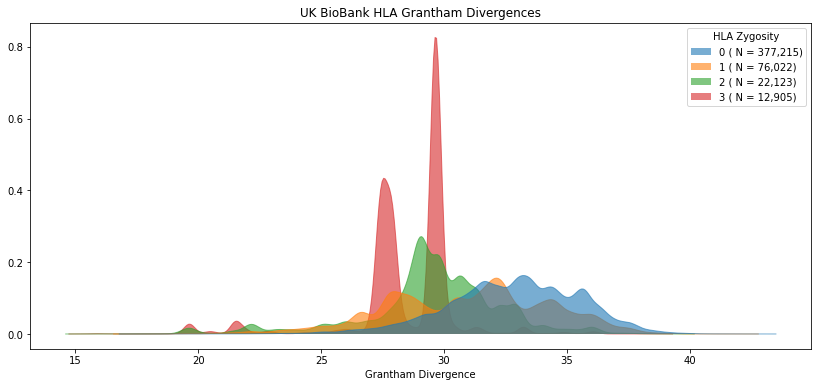

In [12]:
x, hue = "grantham_divergence", "zygosity"

fig, ax = plt.subplots(figsize=(14, 6))
with Timer() as t:
    kde_plot(data=HLA_alleles, x=x, hue=hue, ax=ax, bw=.1)

add_plt_labels(ax, x=x)
ax.set_title("UK BioBank HLA Grantham Divergences")
ax.legend(title="HLA Zygosity")

fig.savefig(constants.COVER_PLOTS_GENERIC_FILE_PATH.format("HLA_grantham_divergences.png"), facecolor="#fffffe")

<AxesSubplot:xlabel='variable', ylabel='value'>

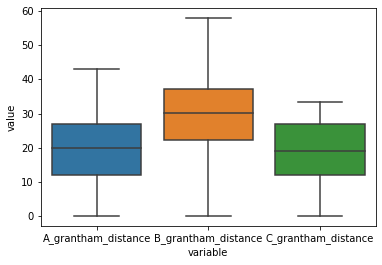

In [13]:
sns.boxplot(data=HLA_alleles[["A_grantham_distance", "B_grantham_distance", "C_grantham_distance"]].melt(),
            x="variable", y="value")